In [62]:
from   datetime import datetime, timedelta
import os.path
import matplotlib.pyplot as plt
import pandas as pd

there is more dataset than these two on github
global recovered cases, US by county..

In [63]:
CONFIRMED_DATASET = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
DEATHS_DATASET = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [64]:
LOCAL_CFILE = 'time_series_covid19_confirmed_global.csv'
LOCAL_DFILE = 'time_series_covid19_deaths_global.csv'


In [65]:
def download():
        # use urllib2 instead ?
        pd.read_csv( CONFIRMED_DATASET ).to_csv( LOCAL_CFILE )
        pd.read_csv( DEATHS_DATASET    ).to_csv( LOCAL_DFILE )


In [66]:
def refresh():
    '''downloads files from github if too old'''
    
    now = datetime.now()
    
    if  os.path.isfile( LOCAL_CFILE ) is False or \
        os.path.isfile( LOCAL_DFILE ) is False or \
        ( now - datetime.fromtimestamp( os.path.getmtime( LOCAL_CFILE) ) ) > timedelta( hours=2 ) or \
        ( now - datetime.fromtimestamp( os.path.getmtime( LOCAL_DFILE) ) ) > timedelta( hours=2 ) :
                
                download()
        

In [67]:
def load():
    '''load csv files from disk into in memory pandas DataFrame'''
    
    refresh()
    # load from memory AND remove full columns with NaN
    df_confirmed = pd.read_csv( LOCAL_CFILE ).dropna( axis=1, how='all', inplace=False )
    df_deaths    = pd.read_csv( LOCAL_DFILE ).dropna( axis=1, how='all', inplace=False )
    
    return (df_confirmed, df_deaths)

In [68]:
df_confirmed, df_deaths = load()

In [69]:
countries_of_interest =  [ "France", "Italy", "United Kingdom", "US", "China" ]
european_countries = [
    'Albania',
    'Austria',
    'Belarus',
    'Belgium',
    'Bosnia',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czech Republic',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Latvia',
    'Ireland',
    'Italy',
    'Lithuania',
    'Luxembourg',
    'Malta',
    'Netherlands',
    'Norway',
    'Portugal',
    'Poland',
    'Romania',
    'San Marino',
    'Serbia',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Sweden',
    'Switzerland',
    'United Kingdom'
]

# Plotting the dataset

three plots
1. total cases against date
2. new cases ( smoothed over a rolling window of 7 days ) against date
3. log/log plot of smoothed new cases as a function of total cases

## About that last plot

lemma:
f is a function f(x) : R->R such that f'(x) = k f(x)  **if and only if** there exist c,k in R such that f(x) = c exp ( k x )

this is one of the well known characterization of the exponential function.

As a result if we consider f(t) = total cases on day t, f'(t) can be approximated with the finite difference: new cases per day.

since there's a variability we smoothe the differnce over a window ...
in the limit, that's f'(t) ...

so, in that plot, the time is not explicitly apparent, and a linear trend means exponential behavior in time.
Without having to shift the curves horizontally to a common reference frame.

The last plot obviously does not need to have log axis to show deviation from exponential behavior.
Log/Log plot makes it easier to handle the beginning of the curve, and makes the end of it more dramatic.




In [76]:
# this is a property of the data format
non_date_columns = 5

# these are choices for display
days_to_ignore = 30

window_size = 7

# not everybody screen is so high res as mine
#figsize=(30,90)
figsize(20,60)

TypeError: 'tuple' object is not callable

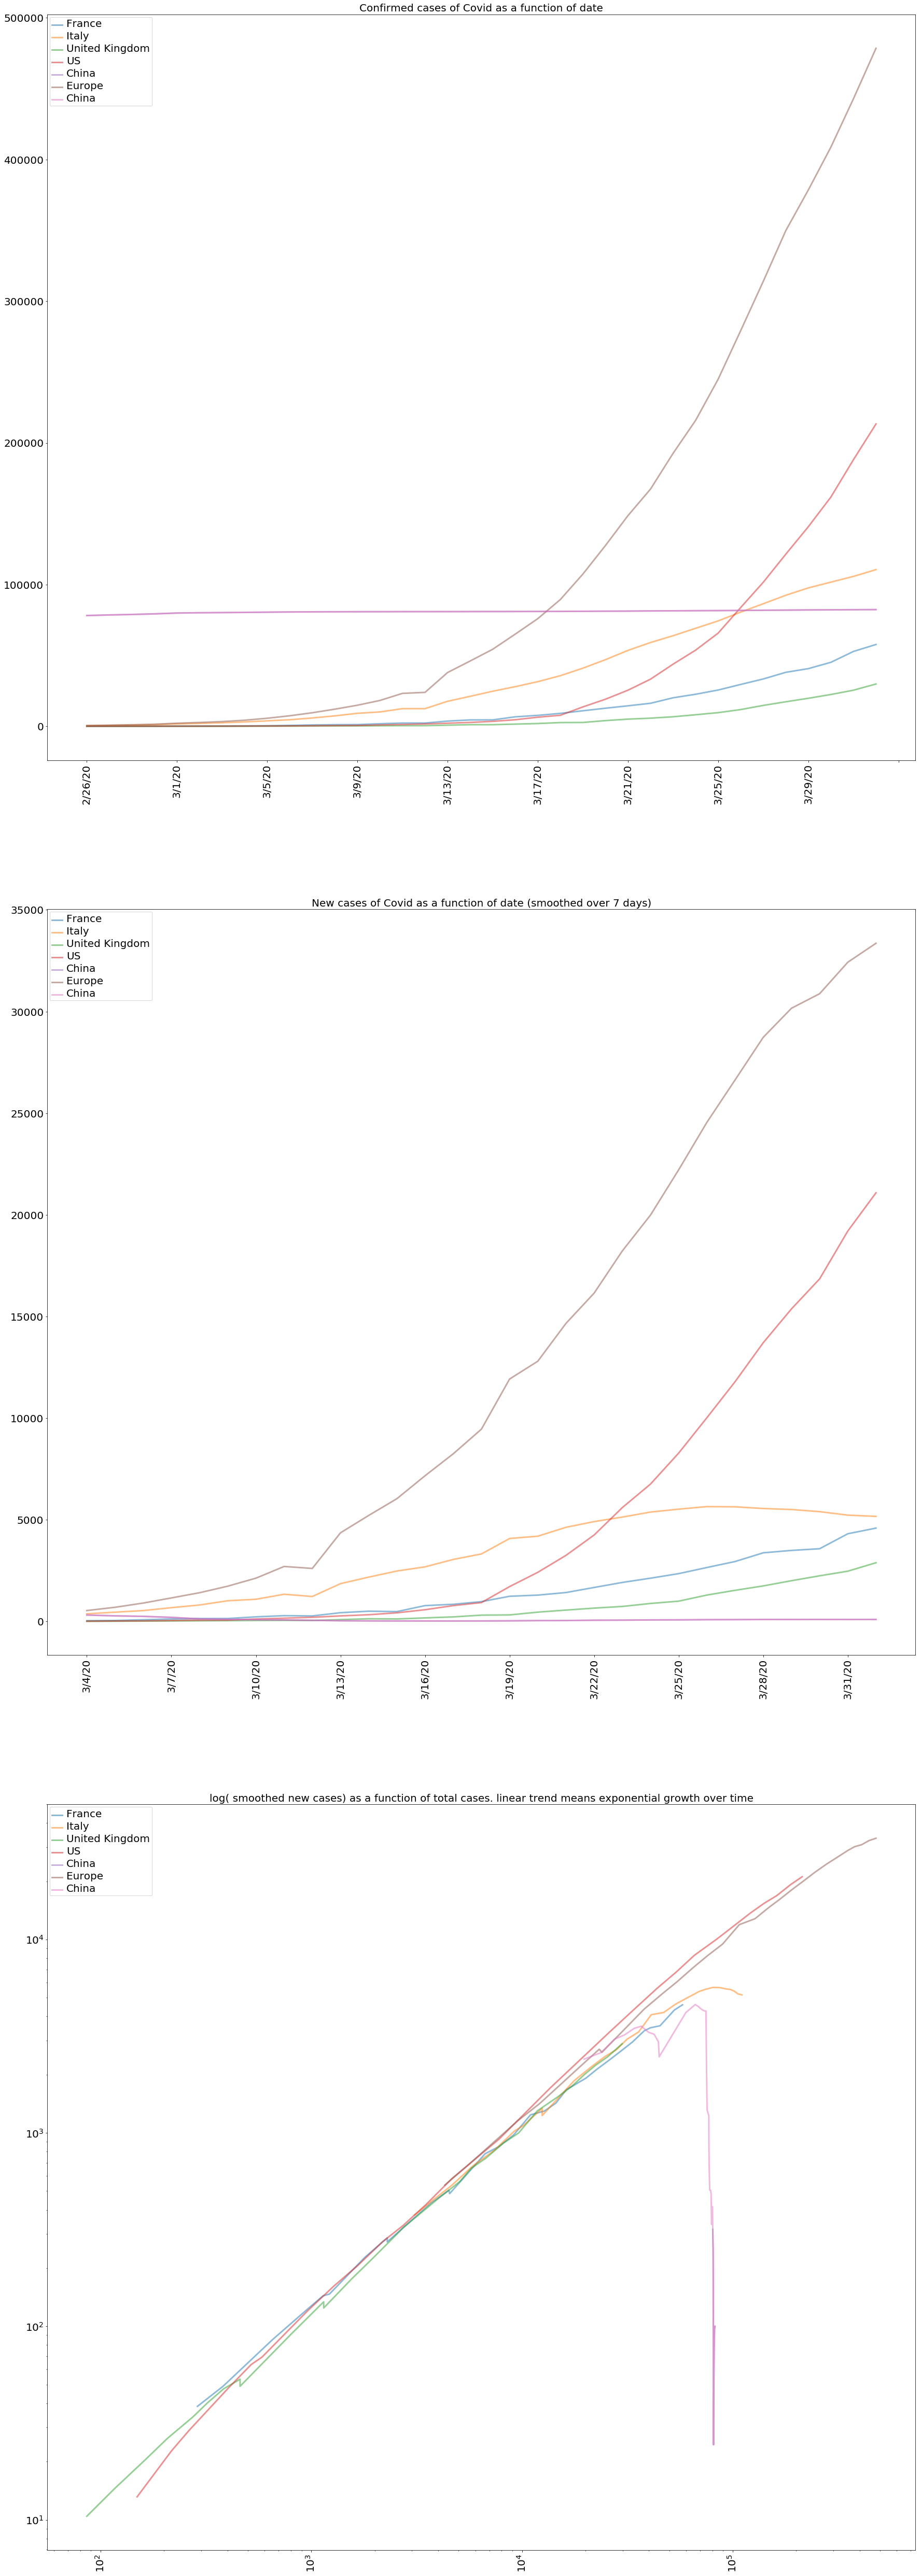

In [77]:
_, (ax1, ax2, ax3) = plt.subplots( 3, 1, figsize=figsize )

for country in countries_of_interest:
    # pick the right row, and the time series portion only. shouldn't have to sum over regions anymore.
    # that's a remnant of the previous dataeset format
    total_cases = df_confirmed.loc[df_confirmed['Country/Region'] == country].filter( regex='.*/20', axis=1 ).sum(0)
    # 
    new_cases = total_cases.diff().dropna()
    smoothed_new_cases = new_cases.rolling( window_size, win_type='boxcar' ).sum().dropna() / window_size
    
    ax1.plot( total_cases[(non_date_columns + days_to_ignore):], lw=3, alpha=0.5, label=country )
    
    ax2.plot( smoothed_new_cases[( non_date_columns + days_to_ignore):],
              lw=3,
              alpha=0.5,
              label=country )
    
    # read above to understand this plot.
    ax3.plot( total_cases[(non_date_columns + days_to_ignore + 1 + window_size -1):],
              smoothed_new_cases[( non_date_columns + days_to_ignore):],
              lw=3,
              alpha=0.5,
              label=country )
             
# european countries as a sum
european_total_cases = df_confirmed.loc[df_confirmed['Country/Region'].isin(european_countries)].filter( regex='.*/20', axis=1 ).sum(0)
european_new_cases   = european_total_cases.diff().dropna()
european_smoothed_new_cases = european_new_cases.rolling( window_size, win_type='boxcar' ).sum().dropna() / window_size

ax1.plot( european_total_cases[(non_date_columns + days_to_ignore):], lw=3, alpha=0.5, label='Europe' )
ax2.plot( european_smoothed_new_cases[( non_date_columns + days_to_ignore):],
          lw=3,
          alpha=0.5,
          label='Europe' )
ax3.plot( european_total_cases[(non_date_columns + days_to_ignore + 1 + window_size -1):],
          european_smoothed_new_cases[( non_date_columns + days_to_ignore):],
          lw=3,
          alpha=0.5,
          label='Europe' )


# China as a sum over regions
chinese_total_cases = df_confirmed.loc[df_confirmed['Country/Region'].isin(['China'])].filter( regex='.*/20', axis=1 ).sum(0)
chinese_new_cases   = chinese_total_cases.diff().dropna()
chinese_smoothed_new_cases = chinese_new_cases.rolling( window_size, win_type='boxcar' ).sum().dropna() / window_size

ax1.plot( chinese_total_cases[(non_date_columns + days_to_ignore):], lw=3, alpha=0.5, label='China' )
ax2.plot( chinese_smoothed_new_cases[( non_date_columns + days_to_ignore):],
          lw=3,
          alpha=0.5,
          label='China' )
# all of China's data
# the plot is not in time. we want all the data ...
ax3.plot( chinese_total_cases[(non_date_columns  + 1 + window_size -1):],
          chinese_smoothed_new_cases[( non_date_columns ):],
          lw=3,
          alpha=0.5,
          label='China' )


ax1.set_title('Confirmed cases of Covid as a function of date')
ax2.set_title('New cases of Covid as a function of date (smoothed over 7 days)')
ax3.set_title( 'log( smoothed new cases) as a function of total cases. linear trend means exponential growth over time')

fontsize=20 

for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(plt.MaxNLocator(12))
        ax.legend()

        for item in ([ ax.title, ax.xaxis.label, ax.yaxis.label ]
                     + ax.get_xticklabels()
                     + ax.get_yticklabels()
                     + ax.get_legend().get_texts()  ):
                item.set_fontsize(fontsize)

        plt.setp( ax.get_xticklabels(), rotation=90)

# the last plot does not have to be log/log
ax3.set_xscale('log')
ax3.set_yscale('log')

plt.show()

In [81]:
def plot_list( df_confirmed, df_label, european_countries, label, column ):
    '''Plot for an arbitrarly list of countries'''
    # this is a property of the data format
    non_date_columns = 5

    # these are choices for display
    days_to_ignore = 30

    window_size = 7

    # not everybody's screen resolution is as fine as mine
    #figsize=(30,90)
    figsize=(20,60)
    
    _, (ax1, ax2, ax3) = plt.subplots( 3, 1, figsize=figsize )

    for country in european_countries:
        # pick the right row, and the time series portion only. shouldn't have to sum over regions anymore.
        # that's a remnant of the previous dataeset format
        total_cases = df_confirmed.loc[df_confirmed[column] == country].filter( regex='.*/20', axis=1 ).sum(0)
        new_cases = total_cases.diff().dropna()
        smoothed_new_cases = new_cases.rolling( window_size, win_type='boxcar' ).sum().dropna() / window_size

        ax1.plot( total_cases[(non_date_columns + days_to_ignore):], lw=3, alpha=0.5, label=country )

        ax2.plot( smoothed_new_cases[( non_date_columns + days_to_ignore):],
                  lw=3,
                  alpha=0.5,
                  label=country )

        ax3.plot( total_cases[(non_date_columns + days_to_ignore + 1 + window_size -1):],
                  smoothed_new_cases[( non_date_columns + days_to_ignore):],
                  lw=3,
                  alpha=0.5,
                  label=country )

    # european countries as a sum
    european_total_cases = df_confirmed.loc[df_confirmed[column].isin(european_countries)].filter( regex='.*/20', axis=1 ).sum(0)
    european_new_cases   = european_total_cases.diff().dropna()
    european_smoothed_new_cases = european_new_cases.rolling( window_size, win_type='boxcar' ).sum().dropna() / window_size

    ax1.plot( european_total_cases[(non_date_columns + days_to_ignore):], lw=3, alpha=0.5, label='All Europe' )
    ax2.plot( european_smoothed_new_cases[( non_date_columns + days_to_ignore):],
              lw=3,
              alpha=0.5,
              label='All ' + label )
    ax3.plot( european_total_cases[(non_date_columns + days_to_ignore + 1 + window_size -1):],
              european_smoothed_new_cases[( non_date_columns + days_to_ignore):],
              lw=3,
              alpha=0.5,
              label='All ' + label )


    ax1.set_title( df_label + ' of Covid as a function of date')
    ax2.set_title('new ' + df_label + ' of Covid as a function of date (smoothed over 7 days)')
    ax3.set_title( 'log( smoothed new ' + df_label + ') as a function of total ' + df_label + '. linear trend means exponential growth over time')

    fontsize=20 

    for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_locator(plt.MaxNLocator(12))
            ax.legend()

            for item in ([ ax.title, ax.xaxis.label, ax.yaxis.label ]
                         + ax.get_xticklabels()
                         + ax.get_yticklabels()
                         + ax.get_legend().get_texts()  ):
                    item.set_fontsize(fontsize)

            plt.setp( ax.get_xticklabels(), rotation=90)

    # the last plot does not have to be log log
    ax3.set_xscale('log')
    ax3.set_yscale('log')

    plt.show()


# Europe only plot

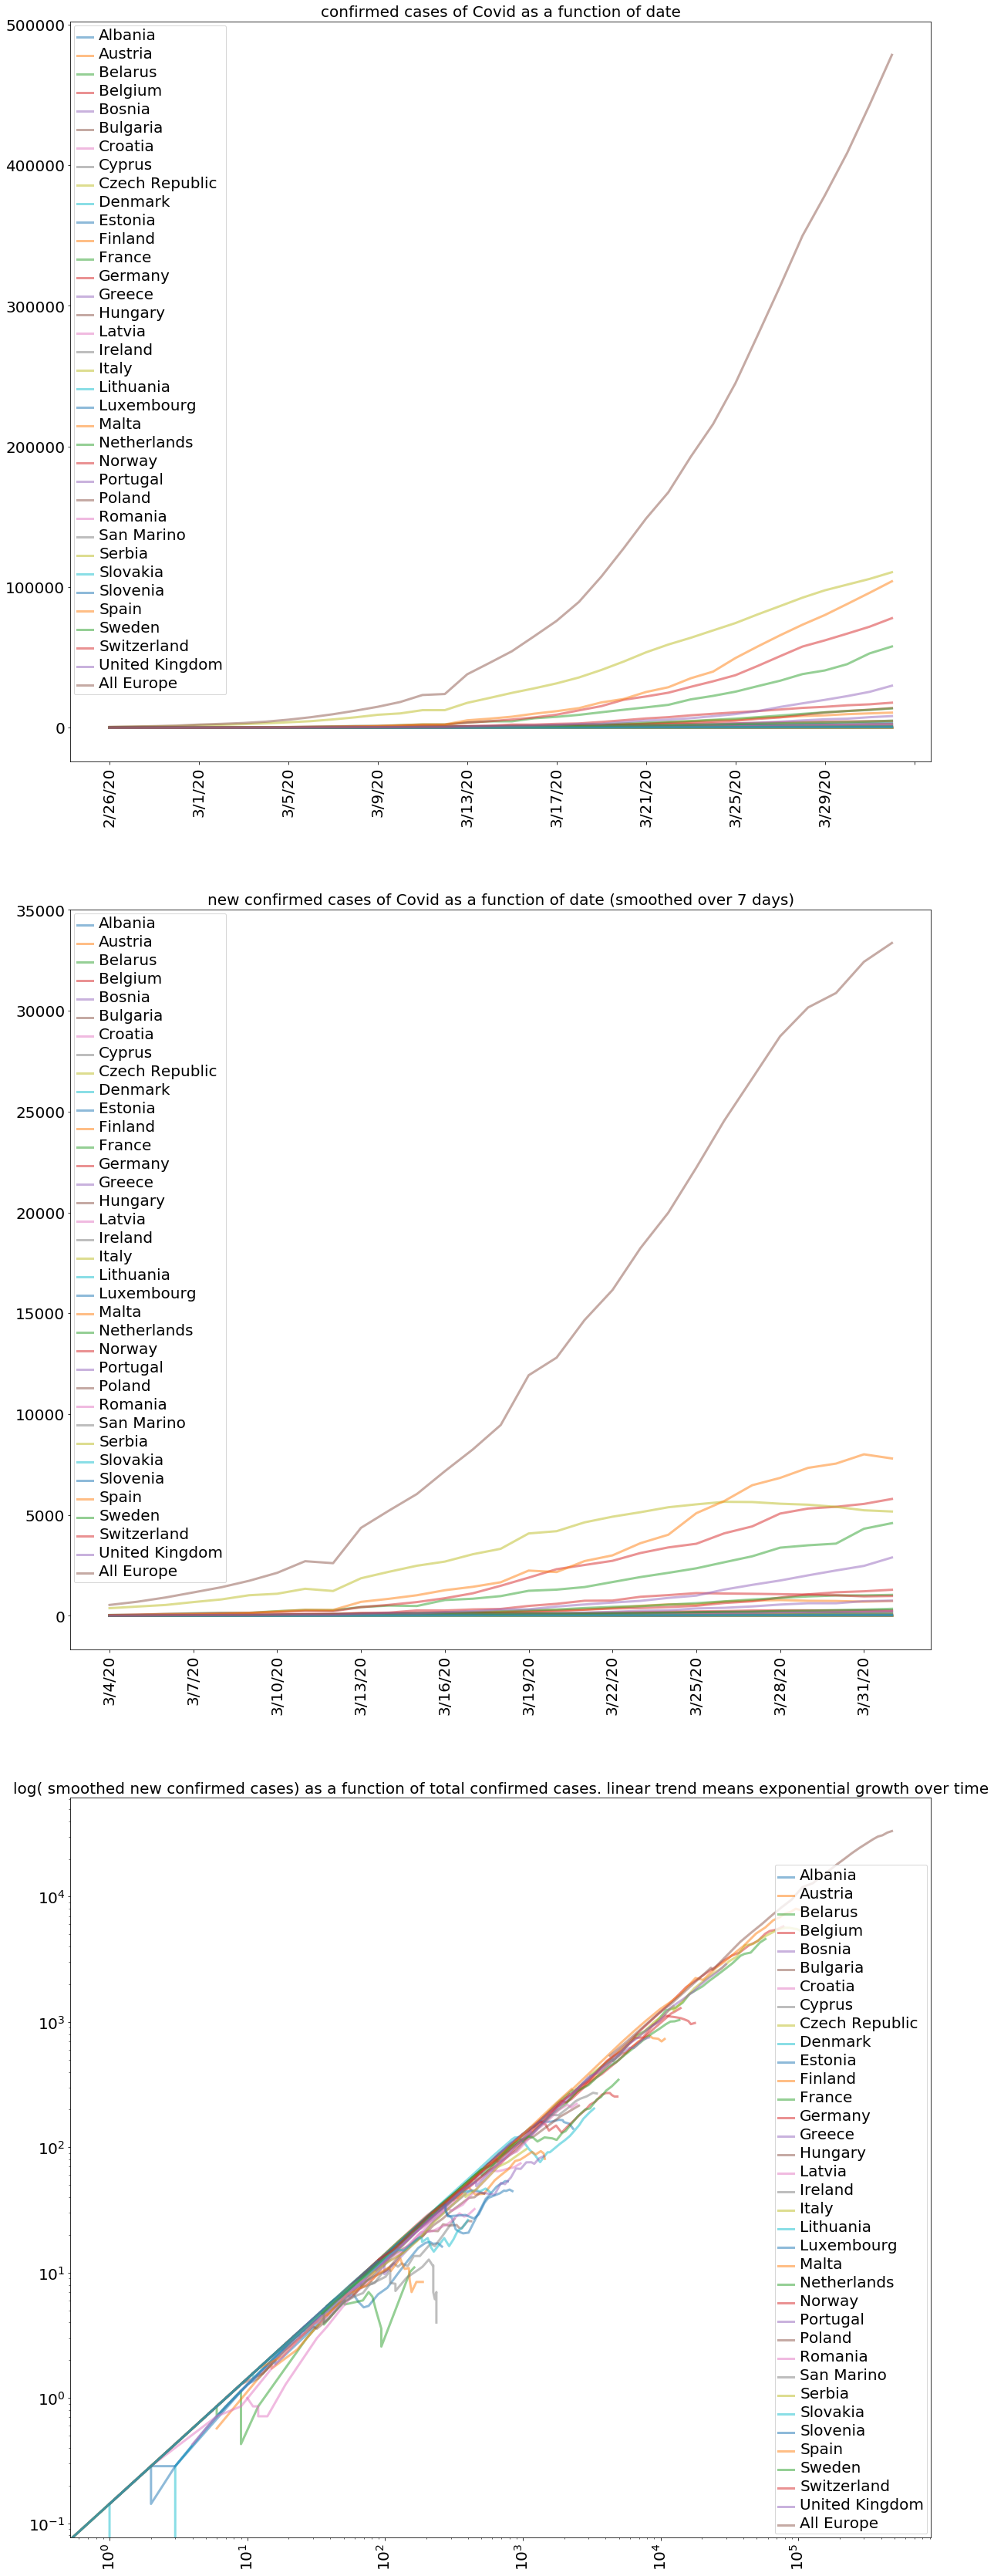

In [82]:
plot_list( df_confirmed, 'confirmed cases', european_countries, 'Europe', 'Country/Region')

# US state by state

In [74]:
US_CONFIRMED_DATASET = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_DEATHS_DATASET = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'

LOCAL_US_CFILE = 'time_series_covid19_confirmed_US.csv'
LOCAL_US_DFILE = 'time_series_covid19_deaths_US.csv'

def download_US():
        # use urllib2 instead ?
        pd.read_csv( US_CONFIRMED_DATASET ).to_csv( LOCAL_US_CFILE )
        pd.read_csv( US_DEATHS_DATASET    ).to_csv( LOCAL_US_DFILE )
        
def refresh_US():
    '''downloads files from github if too old'''
    
    now = datetime.now()
    
    if  os.path.isfile( LOCAL_US_CFILE ) is False or \
        os.path.isfile( LOCAL_US_DFILE ) is False or \
        ( now - datetime.fromtimestamp( os.path.getmtime( LOCAL_US_CFILE) ) ) > timedelta( hours=2 ) or \
        ( now - datetime.fromtimestamp( os.path.getmtime( LOCAL_US_DFILE) ) ) > timedelta( hours=2 ) :
                
                download_US()

def load_US():
    '''load csv files from disk into in memory pandas DataFrame'''
    
    refresh_US()
    # load from memory AND remove full columns with NaN
    df_us_confirmed = pd.read_csv( LOCAL_US_CFILE ).dropna( axis=1, how='all', inplace=False )
    df_us_deaths    = pd.read_csv( LOCAL_US_DFILE ).dropna( axis=1, how='all', inplace=False )
    
    return (df_us_confirmed, df_us_deaths)

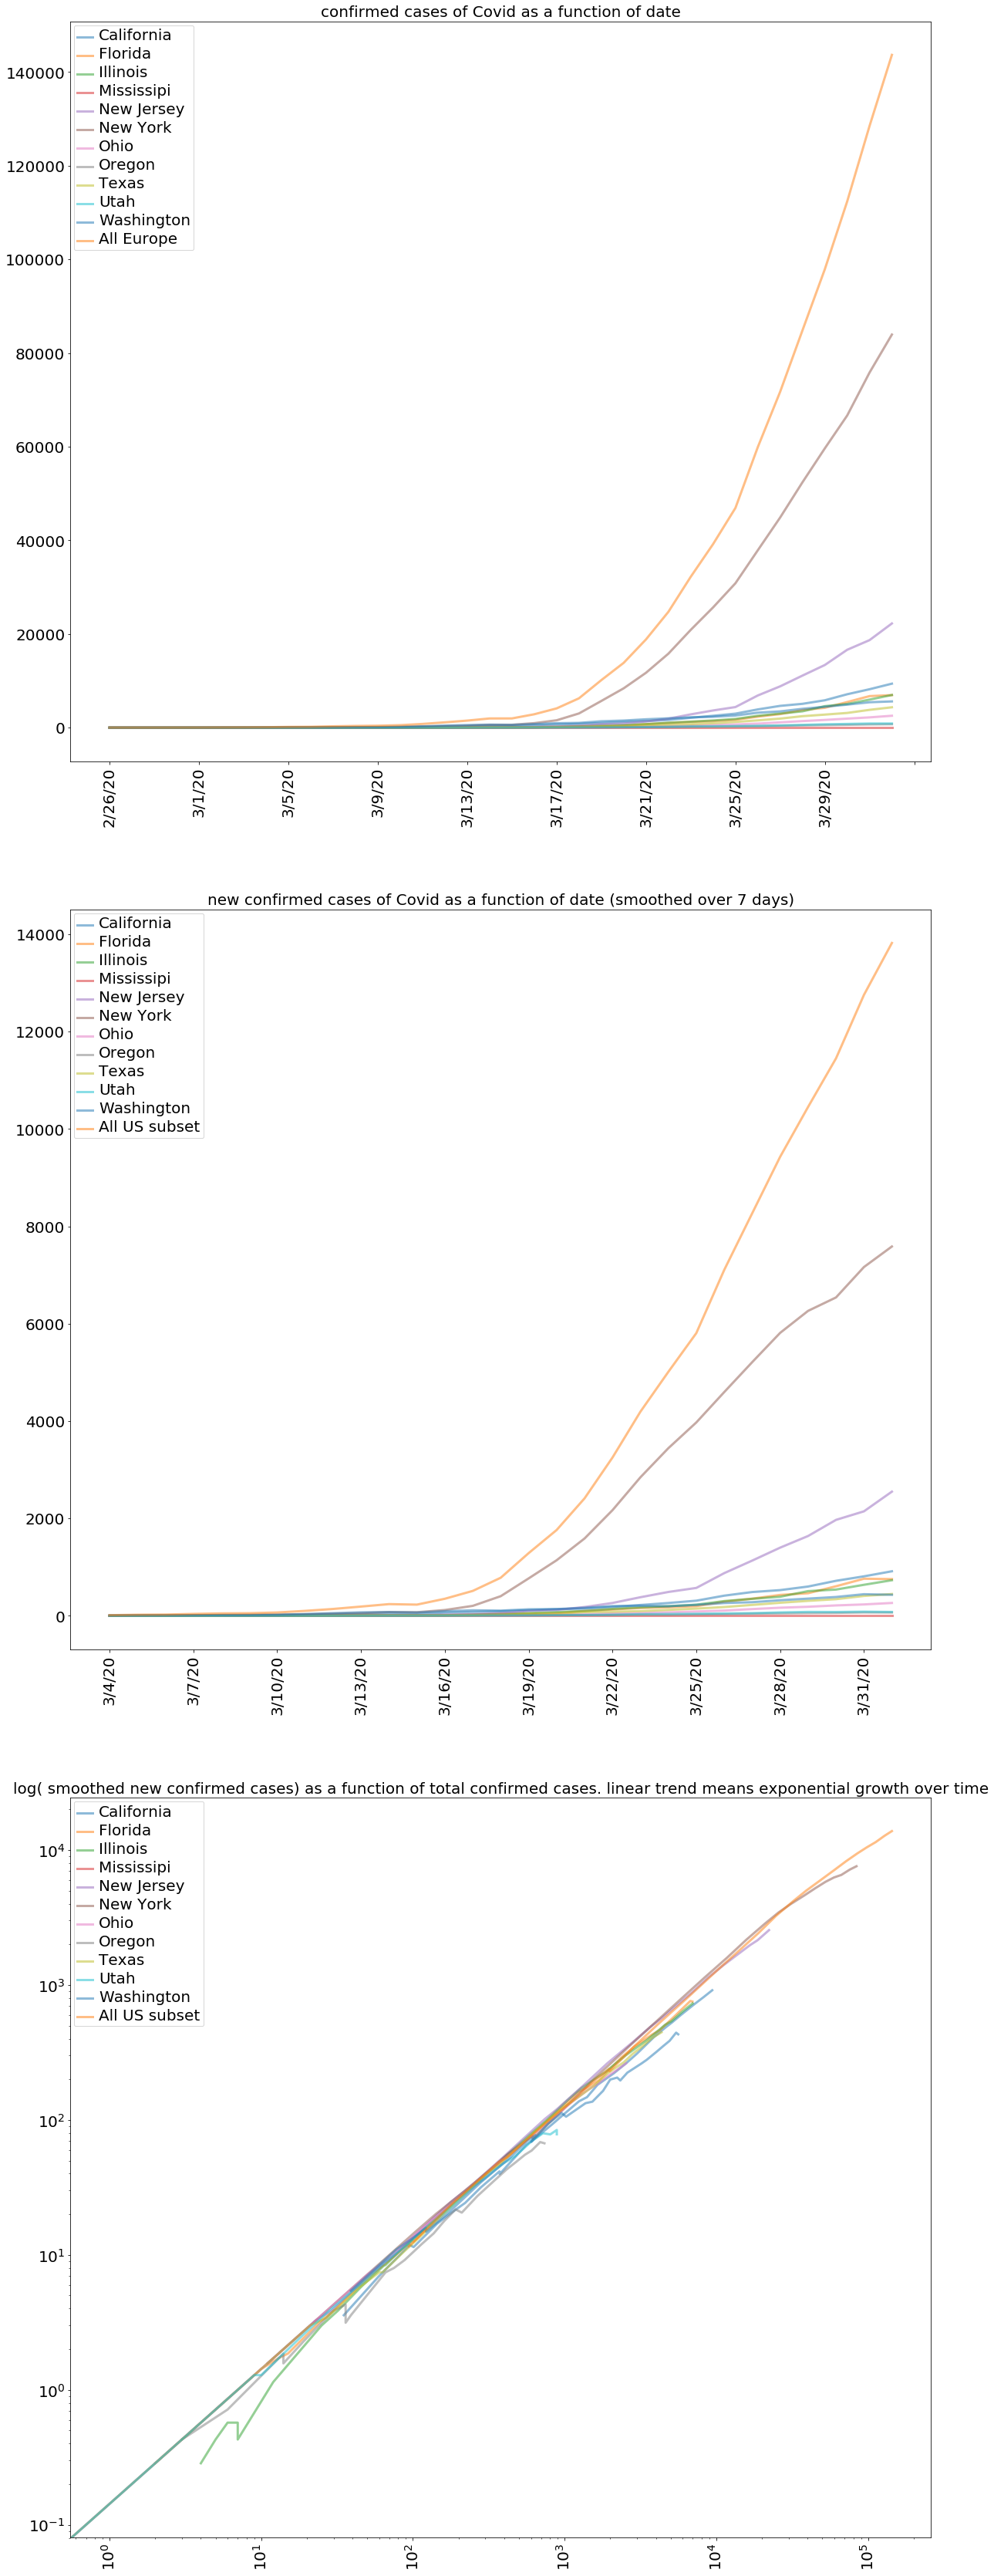

In [83]:
df_us_confirmed, df_us_deaths = load_US()

#print df_us_confirmed

US_states = [ 
    'California', 
    'Florida', 
    'Illinois',
    'Mississipi',
    'New Jersey', 
    'New York',
    'Ohio',
    'Oregon', 
    'Texas',
    'Utah',
    'Washington' 
]

# I make sum in there, I could have matched Country_Region to US to plot all...
plot_list( df_us_confirmed, 'confirmed cases', US_states, 'US subset', 'Province_State')

# California counties of interest